In [1]:
%cd ..

/home/dmoreno/pipeline_v4_final/pipeline/training/stamp_classifier/models/experimentation/stamp_full


In [2]:
import tensorflow as tf
from data_loader import get_tf_datasets
from model import StampModelFull
tf.__version__

2025-06-02 19:20:29.718616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748892029.739931 2510718 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748892029.746144 2510718 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 19:20:29.767548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import det_curve, DetCurveDisplay
from itertools import product

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

In [5]:
normalized_ndarrays = pd.read_pickle('./data/normalized_ndarrays.pkl')
normalized_ndarrays

{'x_train': array([[[[ 1.31217912e-01,  2.08907306e-01, -1.01644330e-01,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 2.04098701e-01,  2.16876030e-01, -3.88859846e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.58876374e-01,  2.10589081e-01, -3.21847685e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],
 
         [[ 1.27885818e-01,  1.91337809e-01, -1.43070174e-02,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.99794412e-01,  1.99527159e-01,  5.73619045e-02,
            0.00000000e+00,  0.000

In [6]:
LabelEncoder = normalized_ndarrays['label_encoder']
del normalized_ndarrays

In [7]:
LabelEncoder

LabelEncoder()

In [8]:
LabelEncoder.classes_

array(['agn', 'asteroid', 'bogus', 'satellite', 'sn', 'vs'], dtype=object)

In [9]:
N_CLASSES = 6
BATCH_SIZE = 64
LABELS = [
    'agn',
    'asteroid',
    'bogus',
    'satellite',
    'sn',
    'vs'
]

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = 'MIG-802fb5a9-d98a-5bce-ad53-9227189dc2cf'

In [11]:
def evaluate_dataset(classifier, dataset):
    y_list = []
    predicted_probs_list = []
    images = []
    for X, pos, y in dataset:
        predicted_probs = tf.nn.softmax(classifier((X, pos)))
        y = y.numpy()
        y_list.append(y)
        predicted_probs_list.append(predicted_probs.numpy())
        images.append(X.numpy())
    predicted_probs = np.concatenate(predicted_probs_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    predictions = tf.argmax(predicted_probs, axis=1).numpy()
    return y, predicted_probs, predictions, images


In [12]:
list(range(1))

[0]

In [13]:
from data_processor import extract_x_pos_y_from_df, normalize_batches

consolidated_dataset_df = pd.read_pickle(os.path.join('data', 'test_first_stamps_dataset.pkl')).reset_index()
print('original shape', consolidated_dataset_df.shape)
# 2869M

# drop stamps that are not 63 x 63 pixels
consolidated_dataset_df['s'] = consolidated_dataset_df['science'].apply(lambda x: x.shape)
consolidated_dataset_df = consolidated_dataset_df[consolidated_dataset_df['s'] == (63, 63)]
# 2876M

# Ghost bogus have duplicates. We will drop them to avoid train-val-test info. leakage
consolidated_dataset_df.drop_duplicates(subset=["oid"], keep='first', inplace=True)
print('shape after drop_duplicates', consolidated_dataset_df.shape)
print(consolidated_dataset_df.groupby('class').count())
# 2876M

consolidated_dataset_df.set_index('oid', inplace=True)
consolidated_dataset_df

original shape (9862, 8)
shape after drop_duplicates (9862, 9)
            oid  candid    ra   dec  science  reference  diff     s
class                                                              
agn        1955    1955  1955  1955     1955       1955  1955  1955
asteroid   1836    1836  1836  1836     1836       1836  1836  1836
bogus      3190    3190  3190  3190     3190       3190  3190  3190
satellite   116     116   116   116      116        116   116   116
sn          723     723   723   723      723        723   723   723
vs         2042    2042  2042  2042     2042       2042  2042  2042


,candid,ra,dec,science,reference,diff,class,s
oid,,,,,,,,
ZTF18acrvifj,696386371515015013,97.911473,44.166678,"[[150.61218, 156.52292, 147.70602, 176.33075, ...","[[158.3742, 158.39339, 161.46977, 160.3848, 15...","[[-1.5471046, -7.7179246, -2.098798, 4.9722285...",asteroid,"(63, 63)"
ZTF20abkxmgb,1288219222015015013,226.357595,46.980558,"[[246.61423, 243.23764, 235.10992, 246.75642, ...","[[240.77872, 243.13548, 242.43506, 247.4099, 2...","[[4.0596557, -4.1685696, 1.623909, -1.1203084,...",bogus,"(63, 63)"
ZTF19acarncj,996206012515010011,310.241926,-17.263419,"[[136.94568, 133.78656, 131.76529, 126.81133, ...","[[134.86603, 131.85738, 132.40509, 131.69608, ...","[[-3.15233, -3.9634652, 3.2999918, 6.501933, 4...",bogus,"(63, 63)"
ZTF20aawjbfj,1211173763415015012,153.997027,26.575844,"[[181.98741, 182.82788, 175.12471, 189.37054, ...","[[180.4975, 181.13257, 182.76552, 183.82341, 1...","[[5.588399, 3.8445094, 1.4256717, 1.5435961, 1...",bogus,"(63, 63)"
ZTF19aacwhdf,739437341315015051,141.613111,16.308071,"[[158.37036, 160.29906, 159.95712, 165.68857, ...","[[162.34294, 161.96933, 164.08528, 162.35286, ...","[[-4.624126, -0.96179765, -4.8974414, 3.573813...",asteroid,"(63, 63)"
...,...,...,...,...,...,...,...,...
ZTF18aagwylf,unknown,253.952703,23.838335,"[[102.38482, 106.80202, 99.84131, 101.54997, 1...","[[103.332535, 104.842, 106.05583, 106.6365, 10...","[[-1.7475458, -1.6464193, -3.4444723, -6.13738...",bogus,"(63, 63)"
ZTF18aarkrua,unknown,164.455587,9.003795,"[[280.43918, 270.82642, 279.51678, 272.69455, ...","[[271.1202, 272.34232, 273.18, 271.08344, 272....","[[9.661203, -6.860366, 9.703698, -0.61737055, ...",bogus,"(63, 63)"
ZTF18aapwhnu,unknown,274.923856,46.905797,"[[88.46057, 74.74536, 87.83728, 98.5011, 98.66...","[[95.3665, 96.60885, 97.618744, 99.76283, 97.8...","[[2.2282143, -21.240143, 3.3253167, -9.664092,...",bogus,"(63, 63)"


In [14]:
oid_test = list(consolidated_dataset_df.index)
x_test, pos_test, y_test = extract_x_pos_y_from_df(consolidated_dataset_df, oid_test)

x_test = np.concatenate([x_test, np.zeros(shape=x_test.shape, dtype=np.float32)], axis=-1)
normalize_batches(x_test, 1000)
y_test = LabelEncoder.transform(y_test).astype(np.int32)

In [15]:
metadata = pd.read_parquet('./data/clipped_normalized_metadata.parquet')
features = sorted(metadata.columns.difference(['oid', 'candid']))
md_test = metadata.loc[oid_test][features]
md_test

,chinr,classtar,dec,diffmaglim,distpsnr1,distpsnr2,distpsnr3,ecl_lat,ecl_long,fwhm,...,magpsf,ncovhist,ndethist,non_detections,ra,sgscore1,sgscore2,sgscore3,sharpnr,sigmapsf
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18acrvifj,-0.092758,0.131694,0.763150,0.131347,1.005053,0.453502,0.651280,-0.107314,-0.703108,0.130368,...,0.132711,-0.760249,0.075372,-0.724391,-0.862256,0.858666,0.107345,-0.176103,-0.002955,0.130583
ZTF20abkxmgb,0.021187,0.131694,0.872662,0.134811,3.947269,-1.693092,-1.868986,1.210460,0.346058,0.126262,...,0.137497,1.519094,0.067695,2.034057,0.431919,0.882572,-3.076215,-2.488906,-1.671810,0.131440
ZTF19acarncj,1.944002,0.129490,-1.627614,0.125235,-0.742868,-1.321911,-1.274174,-0.774986,1.458006,0.148185,...,0.130150,-0.881884,0.067695,-0.869909,1.277106,-0.981147,0.107345,0.192433,1.055050,0.131256
ZTF20aawjbfj,-0.241293,0.131709,0.078542,0.134361,1.068515,0.486893,0.589657,-0.313852,-0.191924,0.146094,...,0.126673,-0.378155,0.067695,-0.260652,-0.297159,-1.171158,-0.922903,-0.515044,-0.490037,0.130992
ZTF19aacwhdf,-0.426453,0.130631,-0.321064,0.133512,1.669318,1.186373,1.154698,-0.769434,-0.267512,0.129748,...,0.141550,-0.739095,0.067695,-0.697206,-0.421935,-1.285676,0.904229,1.039289,-0.737571,0.131492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18aagwylf,-1.544195,-7.626923,-0.027998,-7.626843,-0.951898,-1.693092,-1.868986,0.738977,0.851747,-7.626673,...,-7.626560,-2.338865,-7.608918,-2.630519,0.709957,-3.456638,-3.076215,-2.488906,-3.847708,-7.626928
ZTF18aarkrua,-1.544195,-7.626923,-0.605335,-7.626843,-0.951898,-1.693092,-1.868986,-0.735286,-0.028817,-7.626673,...,-7.626560,-2.338865,-7.608918,-2.630519,-0.191783,-3.456638,-3.076215,-2.488906,-3.847708,-7.626928
ZTF18aapwhnu,-1.544195,-7.626923,0.869752,-7.626843,-0.951898,-1.693092,-1.868986,1.547717,1.171177,-7.626673,...,-7.626560,-2.338865,-7.608918,-2.630519,0.921254,-3.456638,-3.076215,-2.488906,-3.847708,-7.626928


In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(1):  # Para las 5 corridas
   #test_dataset = tf.data.Dataset.from_tensors((x_test, pos_test, y_test))
   test_dataset = tf.data.Dataset.from_tensors((x_test, md_test, y_test))
   test_dataset = test_dataset.unbatch().batch(BATCH_SIZE).prefetch(5)
   
   # Cargar el modelo entrenado para la corrida i
   ## POSITION
   #stamp_classifier = tf.keras.models.load_model(f'results/2025-05-28_17-53-52/run_{i}/model.keras')

   ## Metadatos
   stamp_classifier = tf.keras.models.load_model(f'results/2025-05-29_21-42-49/run_{i}/model.keras')

   # Obtener predicciones
   y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

   y_test_labels = LabelEncoder.inverse_transform(y_test)
   test_predictions_labels = LabelEncoder.inverse_transform(test_predictions)

   # Calcular la matriz de confusión
   conf_matrix = confusion_matrix(y_test_labels, test_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
   all_conf_matrices.append(conf_matrix)

   # Calcular el classification report
   report = classification_report(y_test_labels, test_predictions_labels, output_dict=True)
   all_class_reports.append(report)

I0000 00:00:1748559250.954063 2247938 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1748559254.608145 2247938 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-29 22:54:37.738378: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


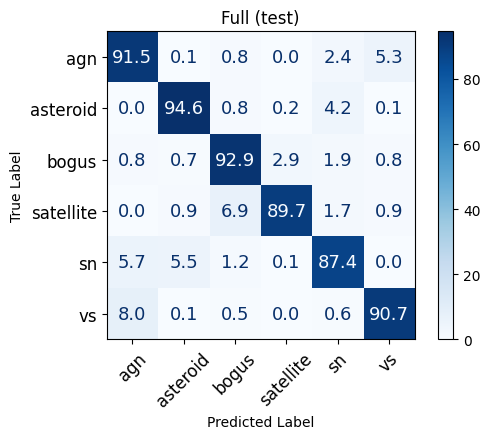

In [20]:
## CON POS
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (test)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [21]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.652131,91.508951,90.057891,0.0,0.0,0.0
asteroid,96.179402,94.607843,95.38715,0.0,0.0,0.0
bogus,98.081376,92.946708,95.445035,0.0,0.0,0.0
satellite,51.485149,89.655172,65.408805,0.0,0.0,0.0
sn,76.052948,87.413555,81.338481,0.0,0.0,0.0
vs,93.440969,90.695397,92.047714,0.0,0.0,0.0


In [22]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,83.981996,91.137938,86.614179,0.0,0.0,0.0


In [23]:
print('******* Test Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Test Set *******
F1: 86.61 ± 0.00
Precision: 83.98 ± 0.00
Recall: 91.14 ± 0.00
************************


In [24]:
f1_test_paper = 86.68
prec_test_paper = 84.34
recall_test_paper = 90.48

macro_report_df[f'f1-score_mean'].values[0] - f1_test_paper

np.float64(-0.06582077120701513)

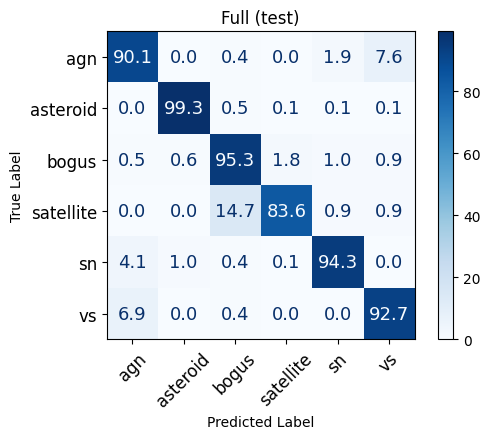

In [17]:
## CON METADATOS
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (test)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [18]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,90.49332,90.076726,90.284542,0.0,0.0,0.0
asteroid,98.593835,99.291939,98.941655,0.0,0.0,0.0
bogus,98.541329,95.297806,96.89243,0.0,0.0,0.0
satellite,62.179487,83.62069,71.323529,0.0,0.0,0.0
sn,90.571049,94.329184,92.411924,0.0,0.0,0.0
vs,91.268693,92.654261,91.956258,0.0,0.0,0.0


In [19]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,88.607952,92.545101,90.301723,0.0,0.0,0.0


In [20]:
print('******* Test Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Test Set *******
F1: 90.30 ± 0.00
Precision: 88.61 ± 0.00
Recall: 92.55 ± 0.00
************************


In [21]:
f1_test_paper = 86.68
prec_test_paper = 84.34
recall_test_paper = 90.48

macro_report_df[f'f1-score_mean'].values[0] - f1_test_paper

np.float64(3.621723198107162)

0.19372195662717218

In [38]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

dataset_name = 'full'
BATCH_SIZE = 32  # Ajusta según tu configuración

all_conf_matrices = []
all_class_reports = []

for i in range(5):  # Para las 5 corridas
    with tf.device('/cpu:0'):
        training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
            dataset_name=dataset_name, batch_size=BATCH_SIZE)
        
        # Cargar el modelo entrenado para la corrida i
        stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')

        # Obtener predicciones
        y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

        y_val_labels = LabelEncoder.inverse_transform(y_val)
        val_predictions_labels = LabelEncoder.inverse_transform(val_predictions)

        # Calcular la matriz de confusión
        conf_matrix = confusion_matrix(y_val_labels, val_predictions_labels, labels=LabelEncoder.classes_, normalize='true')
        all_conf_matrices.append(conf_matrix)

        # Calcular el classification report
        report = classification_report(y_val_labels, val_predictions_labels, output_dict=True)
        all_class_reports.append(report)

x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:31.357988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:41:41.030626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:41:52.047254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:01.458283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:12.153323: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_2/Assert/AssertGuard/branch_executed/_66
2025-02-07 08:42:21.494043: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90_1/Assert/AssertGuard/branch_executed/_47


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:32.456927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:42:41.868318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


x_train.shape final (29586, 63, 63, 6)


2025-02-07 08:42:52.767949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28
2025-02-07 08:43:02.335785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/rot90/Assert/AssertGuard/branch_executed/_28


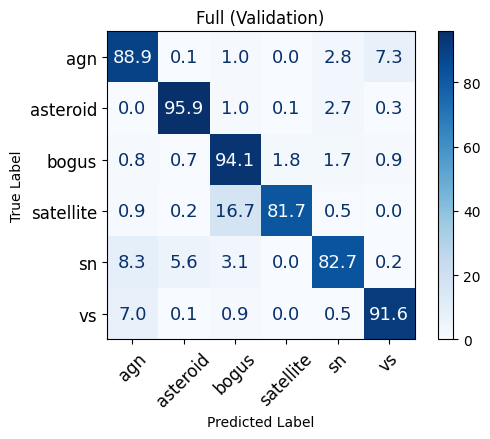

In [45]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0) * 100

# **2. Graficar la matriz de confusión promedio**
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix, display_labels=LabelEncoder.classes_,)
disp.plot(ax=ax, cmap="Blues", values_format=".1f")

# Ajustes de etiquetas y títulos
plt.xticks(rotation=45, fontsize=12)  # Rotar el eje X
plt.yticks(fontsize=12)  # Aumentar el tamaño en el eje Y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Full (Validation)")

# Ajuste del tamaño del texto dentro de la matriz
for text in ax.texts:
    text.set_fontsize(13)  # Aumentar tamaño de los valores en la matriz
plt.show()

In [40]:
# **3. Calcular la media y desviación estándar del classification report**
labels = list(all_class_reports[0].keys())[:-3]  # Excluye 'accuracy', 'macro avg' y 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrame para almacenar resultados
report_df = pd.DataFrame(index=labels, columns=[f'{m}_mean' for m in metrics] + [f'{m}_std' for m in metrics])

# Calcular media y desviación estándar para cada métrica
for label in labels:
    for metric in metrics:
        values = [rep[label][metric] for rep in all_class_reports]
        report_df.at[label, f'{metric}_mean'] = np.mean(values)
        report_df.at[label, f'{metric}_std'] = np.std(values)

report_df*100

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
agn,88.270347,88.890026,88.545391,1.268922,2.239778,0.558263
asteroid,96.461751,95.893246,96.167177,0.698752,1.376865,0.540942
bogus,96.868027,94.087774,95.452292,0.765394,0.704765,0.166169
satellite,61.871745,81.724138,70.31949,2.09429,4.021346,0.987691
sn,78.379359,82.710927,80.36352,3.885095,2.547356,1.231768
vs,91.360904,91.576885,91.43387,1.795535,1.807045,0.224377


In [42]:
# Extraer las métricas macro promedio y su desviación estándar
macro_metrics = ['macro avg']  # Puedes agregar 'weighted avg' si lo necesitas

# Crear DataFrame para los macro promedios
macro_report_df = pd.DataFrame(index=macro_metrics, columns=[f'{m}_mean' for m in ['precision', 'recall', 'f1-score']] +
                                                            [f'{m}_std' for m in ['precision', 'recall', 'f1-score']])

# Calcular media y desviación estándar para los macros
for metric in ['precision', 'recall', 'f1-score']:
    values = [rep['macro avg'][metric] for rep in all_class_reports]
    macro_report_df.at['macro avg', f'{metric}_mean'] = np.mean(values) * 100
    macro_report_df.at['macro avg', f'{metric}_std'] = np.std(values) * 100

macro_report_df

,precision_mean,recall_mean,f1-score_mean,precision_std,recall_std,f1-score_std
macro avg,85.535356,89.147166,87.046957,0.512067,0.593025,0.254697


In [43]:
print('******* Validation Set *******')
print(f"F1: {macro_report_df[f'f1-score_mean'].values[0]:.2f} ± {macro_report_df[f'f1-score_std'].values[0]:.2f}") 
print(f"Precision: {macro_report_df[f'precision_mean'].values[0]:.2f} ± {macro_report_df[f'precision_std'].values[0]:.2f}") 
print(f"Recall: {macro_report_df[f'recall_mean'].values[0]:.2f} ± {macro_report_df[f'recall_std'].values[0]:.2f}") 
print('************************')

******* Validation Set *******
F1: 87.05 ± 0.25
Precision: 85.54 ± 0.51
Recall: 89.15 ± 0.59
************************


In [ ]:
mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(figsize, figsize)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_xlabel('Predicted Label', fontsize=fs+2)
ax.set_ylabel('True Label', fontsize=fs+2)

ax.xaxis.label.set_size(fs+2)
ax.yaxis.label.set_size(fs+2)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.savefig(path_save)
plt.close(fig)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Mean Confusion Matrix Over 5 Runs")
plt.show()

In [18]:
dataset_name = 'full'
i = 0

with tf.device('/cpu:0'):
    training_dataset, validation_dataset, test_dataset, label_encoder = get_tf_datasets(
        dataset_name=dataset_name, batch_size=BATCH_SIZE)
    #stamp_classifier = tf.keras.models.load_model(f'saved_models/{dataset_name}_run_{i}/')
    stamp_classifier = tf.keras.models.load_model(f'{dataset_name}_run_{i}/')
    y_val, val_predicted_probs, val_predictions, images_val = evaluate_dataset(stamp_classifier, validation_dataset)

print('y_val:', y_val.shape)
print('val_predictions:', val_predictions.shape)

(9862,)

In [14]:
with tf.device('/cpu:0'):
    y_test, test_predicted_probs, test_predictions, images_test = evaluate_dataset(stamp_classifier, test_dataset)

In [ ]:
print('y_test:', y_test.shape)
print('test_predictions:', test_predictions.shape)

In [45]:
for b in validation_dataset:
    print(b)
    break

(<tf.Tensor: shape=(64, 63, 63, 6), dtype=float32, numpy=
array([[[[ 5.55989780e-02,  2.77429610e-01, -3.79745066e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 9.00271088e-02,  2.71785200e-01,  1.48523405e-01,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.00318424e-02,  2.72807121e-01,  2.99650021e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 6.52558804e-02,  2.78823227e-01,  6.73804358e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.78682733e-02,  2.81814069e-01,  2.02923119e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.18669274e-02,  2.79148817e-01,  1.14476290e-02,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 6.76989928e-02,  2.76165426e-01,  6.55059516e-03,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.14817338e-02,  2.77233958e-01, -1.95179328e-01,
    

In [35]:
satellite_cands = images[val_predicted_probs[:, 3] > 0.8]

In [25]:
images = np.concatenate(images, axis=0)
images.shape

(9862, 63, 63, 6)

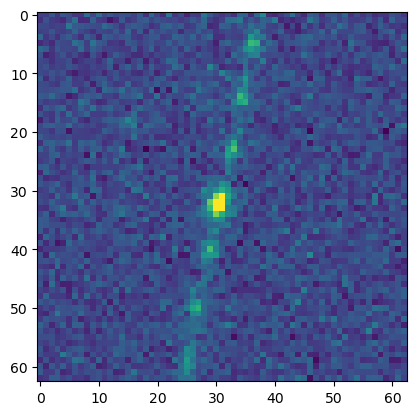

In [44]:
plt.imshow(satellite_cands[8, :, :, 0])